# JetgraphDataset v5
In this notebook we show the new version of JetgraphDataset, where we build our dataset ***directly from raw data***. 

Thanks to the new pipeline used to build graphs, we have way more control on the dataset settings and graphs' building methods. 

In addition, after first download and preprocessing, this version is much faster, thus making it possible to perform more experiments in shorter time.

### Configure notebook
We first download and install necessary libraries.

In [ ]:
# We use a CPU-based installation, but you can vary it easily from the PyG website:
# https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
%%capture
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html

🎉🎉🎉  We now have a custom library to manipulate jetgraphs, we can install it from github with:

In [ ]:
%%capture
!pip install git+https://github.com/alessiodevoto/jetgraphs.git

### Download dataset 
The dataset mechanics are slightly different from other versions. 


#### 1. Define strategy to build graphs
In order to have full control over the edges, we use our custom transform `jetgraphs.transforms.BuildEdges`. 
Through this, we can decide:

- `directed`: if the dataset should be directed
- `same_layer_threshold`: what is the maximum same layer distance to connect two nodes
- `consecutive_layer_threshold`: what is the maximum consecutive layer distance to connect two nodes
- `self_loop_weight`: what edge attribute to assign to self loops.
- `distance_p`: how should the distance between two nodes be computed? {1=manhattan, 2=euclidean}

Thanks to this transform, it's now easy to decide the graph building policy and test different settings, for instance the edge thresholds.

In [ ]:
from jetgraphs.transforms import BuildEdges

edge_builder = BuildEdges(
    directed=False, 
    self_loop_weight=1,
    same_layer_threshold=0.6, 
    consecutive_layer_threshold=0.6,
    distance_p=2)

#### 2. Add optional transforms 
Optionally, we can also add other transforms. All transforms are found in `jetgraphs.transforms`.

Here we just use `NumLayers` and `LayersNum`, that respectively add to each data object the number of layers and the ids of layers (e.g. [1,4] ) found in that graph.

In [ ]:
from torch_geometric.transforms import Compose 
from jetgraphs.transforms import NumLayers, LayersNum
optional_transforms = Compose([NumLayers(), LayersNum()])

#### 3. Download dataset
🛑 Remark: After the inital download and preprocessing (this url is slower than the others), a saved preprocessed version is kept on disk, so that any further processing will be much quicker.


We can download and build the dataset like so:


In [ ]:
from jetgraphs.JetGraphDataset import JetGraphDatasetInMemory_v2

datasets_root = "/content/drive/MyDrive/jetgraphs_workspace/datasets"
raw_data_url = ""

jet_graph_dataset = JetGraphDatasetInMemory_v2(
    root = datasets_root,   # directory where to download data 
    url = raw_data_url,     # url to raw data
    subset = '100%',        # which subset of the intial 100k graph to consider, default is 100%
    min_num_nodes = 2,      # only include graphs with at least 2 nodes 
    transform =  optional_transforms,
    pre_transform = edge_builder) # edge_builder should be passed as pre_transform to keep data on disk.

Processing...


[Processing] Loading preprocessed data...
[Processing] Selecting 100000 graphs from the initial 100000.
[Processing] Graphs will be 25000 from Background 0, 25000 from Background 1, and 50000 from Signal subdir.
[Processing] Applying pre transform...


100%|██████████| 100000/100000 [06:52<00:00, 242.18it/s]
Done!


Loaded dataset with name min_nodes_2, containing subset of 100%


#### 4. New graph plotting function
The new function to plot a single graph offers a lot of new features. 
Most important are:
- we can control the angle and elevation of the plot (i.e. change the point of view) (`elev` and `angle`)
- we can decide whether higher energy nodes should be bigger in the plot (`energy_is_size`) 
- we can draw nodes belonging to differnt layers in different colors `color_layers`


In [ ]:
g = jet_graph_dataset[75000]
g

Data(x=[12, 4], y=[1], edge_attr=[124, 1], edge_index=[2, 124], num_layers=3, layers_num='[0, 1, 2]')

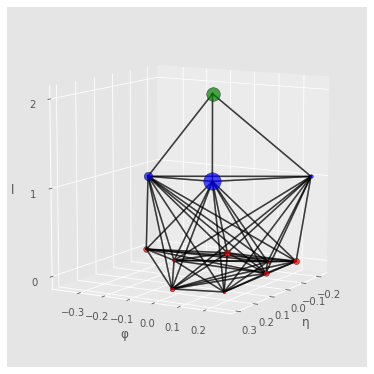

In [ ]:
from jetgraphs.utils import plot_jet_graph

plot_jet_graph(
    g, 
    angle=30, 
    elev=10, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

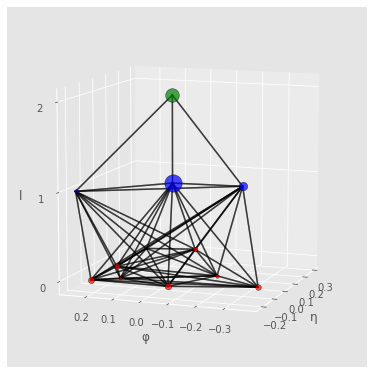

In [ ]:
plot_jet_graph(
    g, 
    angle=200, 
    elev=10, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

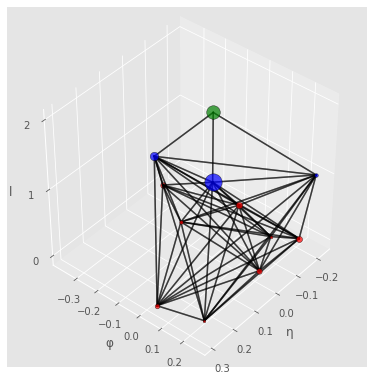

In [ ]:
plot_jet_graph(
    g, 
    angle=40, 
    elev=40, 
    color_layers=True, 
    energy_is_size=True,  
    save_to_path=False)

#### 5. Export dataset to pandas and plot overall statistics 
We also have new tools for analysing the dataset in Pandas format automatically.  
We can export the dataset to pandas thanks to `jetgraphs.utils.stats_to_pandas` and then plot info with `jetgraphs.utils.plot_dataset_info2`


In [ ]:
from jetgraphs.utils import stats_to_pandas

df = stats_to_pandas(
    jet_graph_dataset, 
    # include fields of Data objects that were added by transforms
    additional_col_names=['layers_num', 'num_layers'] 
    )
df

,class,num_nodes,num_edges,layers_num,num_layers
0,1,5,13,"[0, 2]",2
1,1,5,17,"[0, 1, 3]",3
2,1,5,19,"[0, 1, 2]",3
3,1,6,36,[0],1
4,1,2,2,"[0, 2]",2
...,...,...,...,...,...
99995,0,7,25,"[0, 1, 2]",3
99996,0,6,24,"[0, 1, 2]",3
99997,0,12,122,"[0, 1, 2]",3
99998,0,11,83,"[0, 1, 2]",3


We also have some utils to plot dataset features. 

Creating plots for columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'] from dataset with columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'])


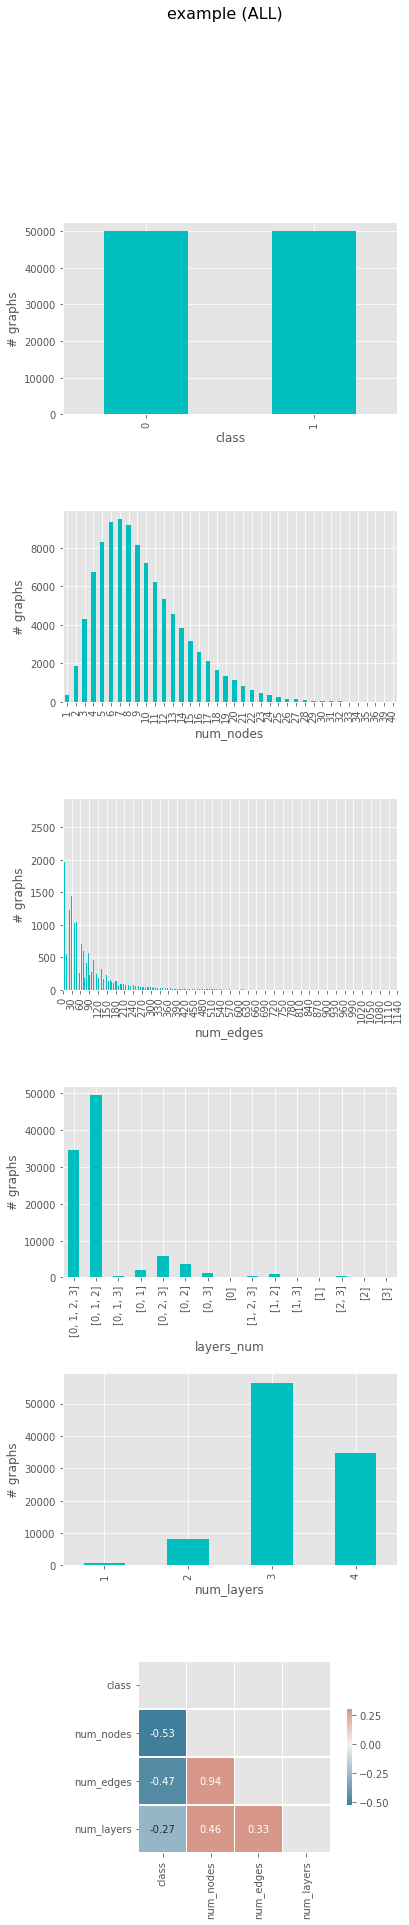

In [ ]:
from jetgraphs.utils import plot_dataset_info

plot_dataset_info(df, 
                   title='example',
                   include_cols=False,
                   exclude_cols=False,
                   separate_classes=False,
                   save_to_path=False
                   )

Creating plots for columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'] from dataset with columns: ['class', 'num_nodes', 'num_edges', 'layers_num', 'num_layers'])


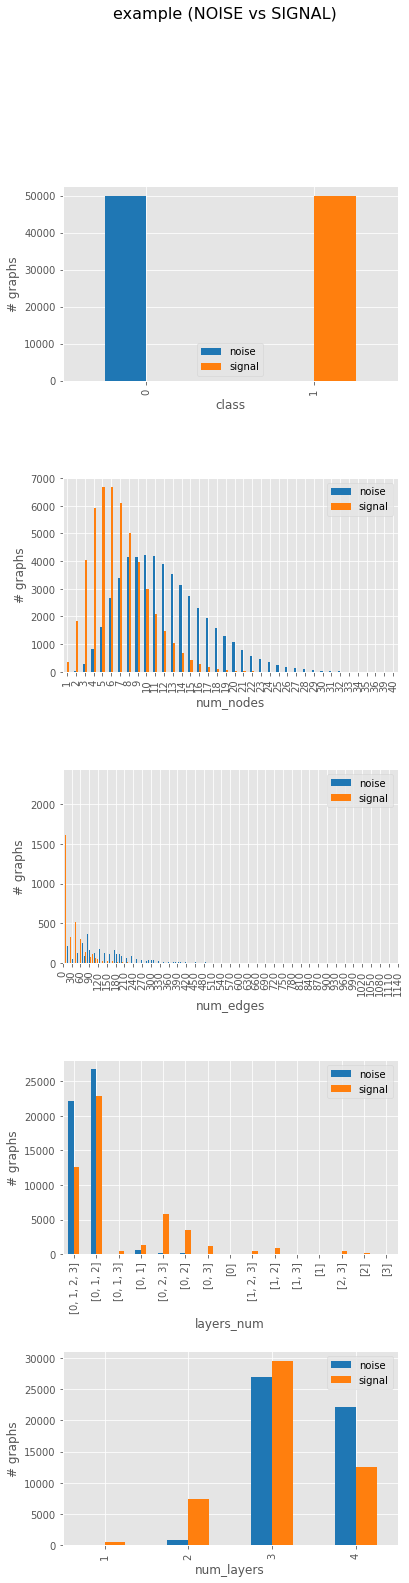

In [ ]:
plot_dataset_info(df, 
                   title='example',
                   include_cols=False, 
                   exclude_cols=False, # in case we want to exclude, say, the class graph
                   separate_classes=True,
                   save_to_path=False
                   )